# Bitcoin Returns
This project is based on my 4th year thesis project which was looking at timeseries momentum for cryptocurrency returns. In the thesis, I found conclusive evidence that past returns do have some impact on future returns at the monthly and weekly levels and discovered this by basic linear regression. In this project, I aim to go further and look at the impact of past returns combined with past trading volume and see how well this predicts future daily returns. This project will mainly focus on using the machine learning models that I've been exposed to during this class.

The dataset is from Yahoo Finance - https://finance.yahoo.com/quote/BTC-USD/

First, we import the requried libraries and dataset.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier

import sklearn as sk




In [14]:
df = pd.read_csv('BTC-USD.csv')
#recognize the date column as a datetime object in pandas
df['Date'] = pd.to_datetime(df['Date'])
#set the date as the index
df.set_index('Date', inplace=True)
#we'll keep only the open price and volume 
df.drop(columns=['High', 'Low', 'Close', 'Adj Close'],  inplace=True)

Calculate the daily returns and percentage change in volume. Focusing on returns and percentage change in volume aims to make the data 'stationary' and facilitates more accurate prediction and inference.

In [15]:
df['daily_pct_chg'] = df['Open'].pct_change(periods=1)
df['daily_pct_chg_vol'] = df['Volume'].pct_change(periods=1)
df.dropna(inplace=True)
print(df.head())

                  Open    Volume  daily_pct_chg  daily_pct_chg_vol
Date                                                              
2014-09-18  456.859985  34483200      -0.019328           0.637628
2014-09-19  424.102997  37919700      -0.071700           0.099657
2014-09-20  394.673004  36863600      -0.069394          -0.027851
2014-09-21  408.084991  26580100       0.033983          -0.278961
2014-09-22  399.100006  24127600      -0.022017          -0.092268


Let's see how the returns look with a few graphs.

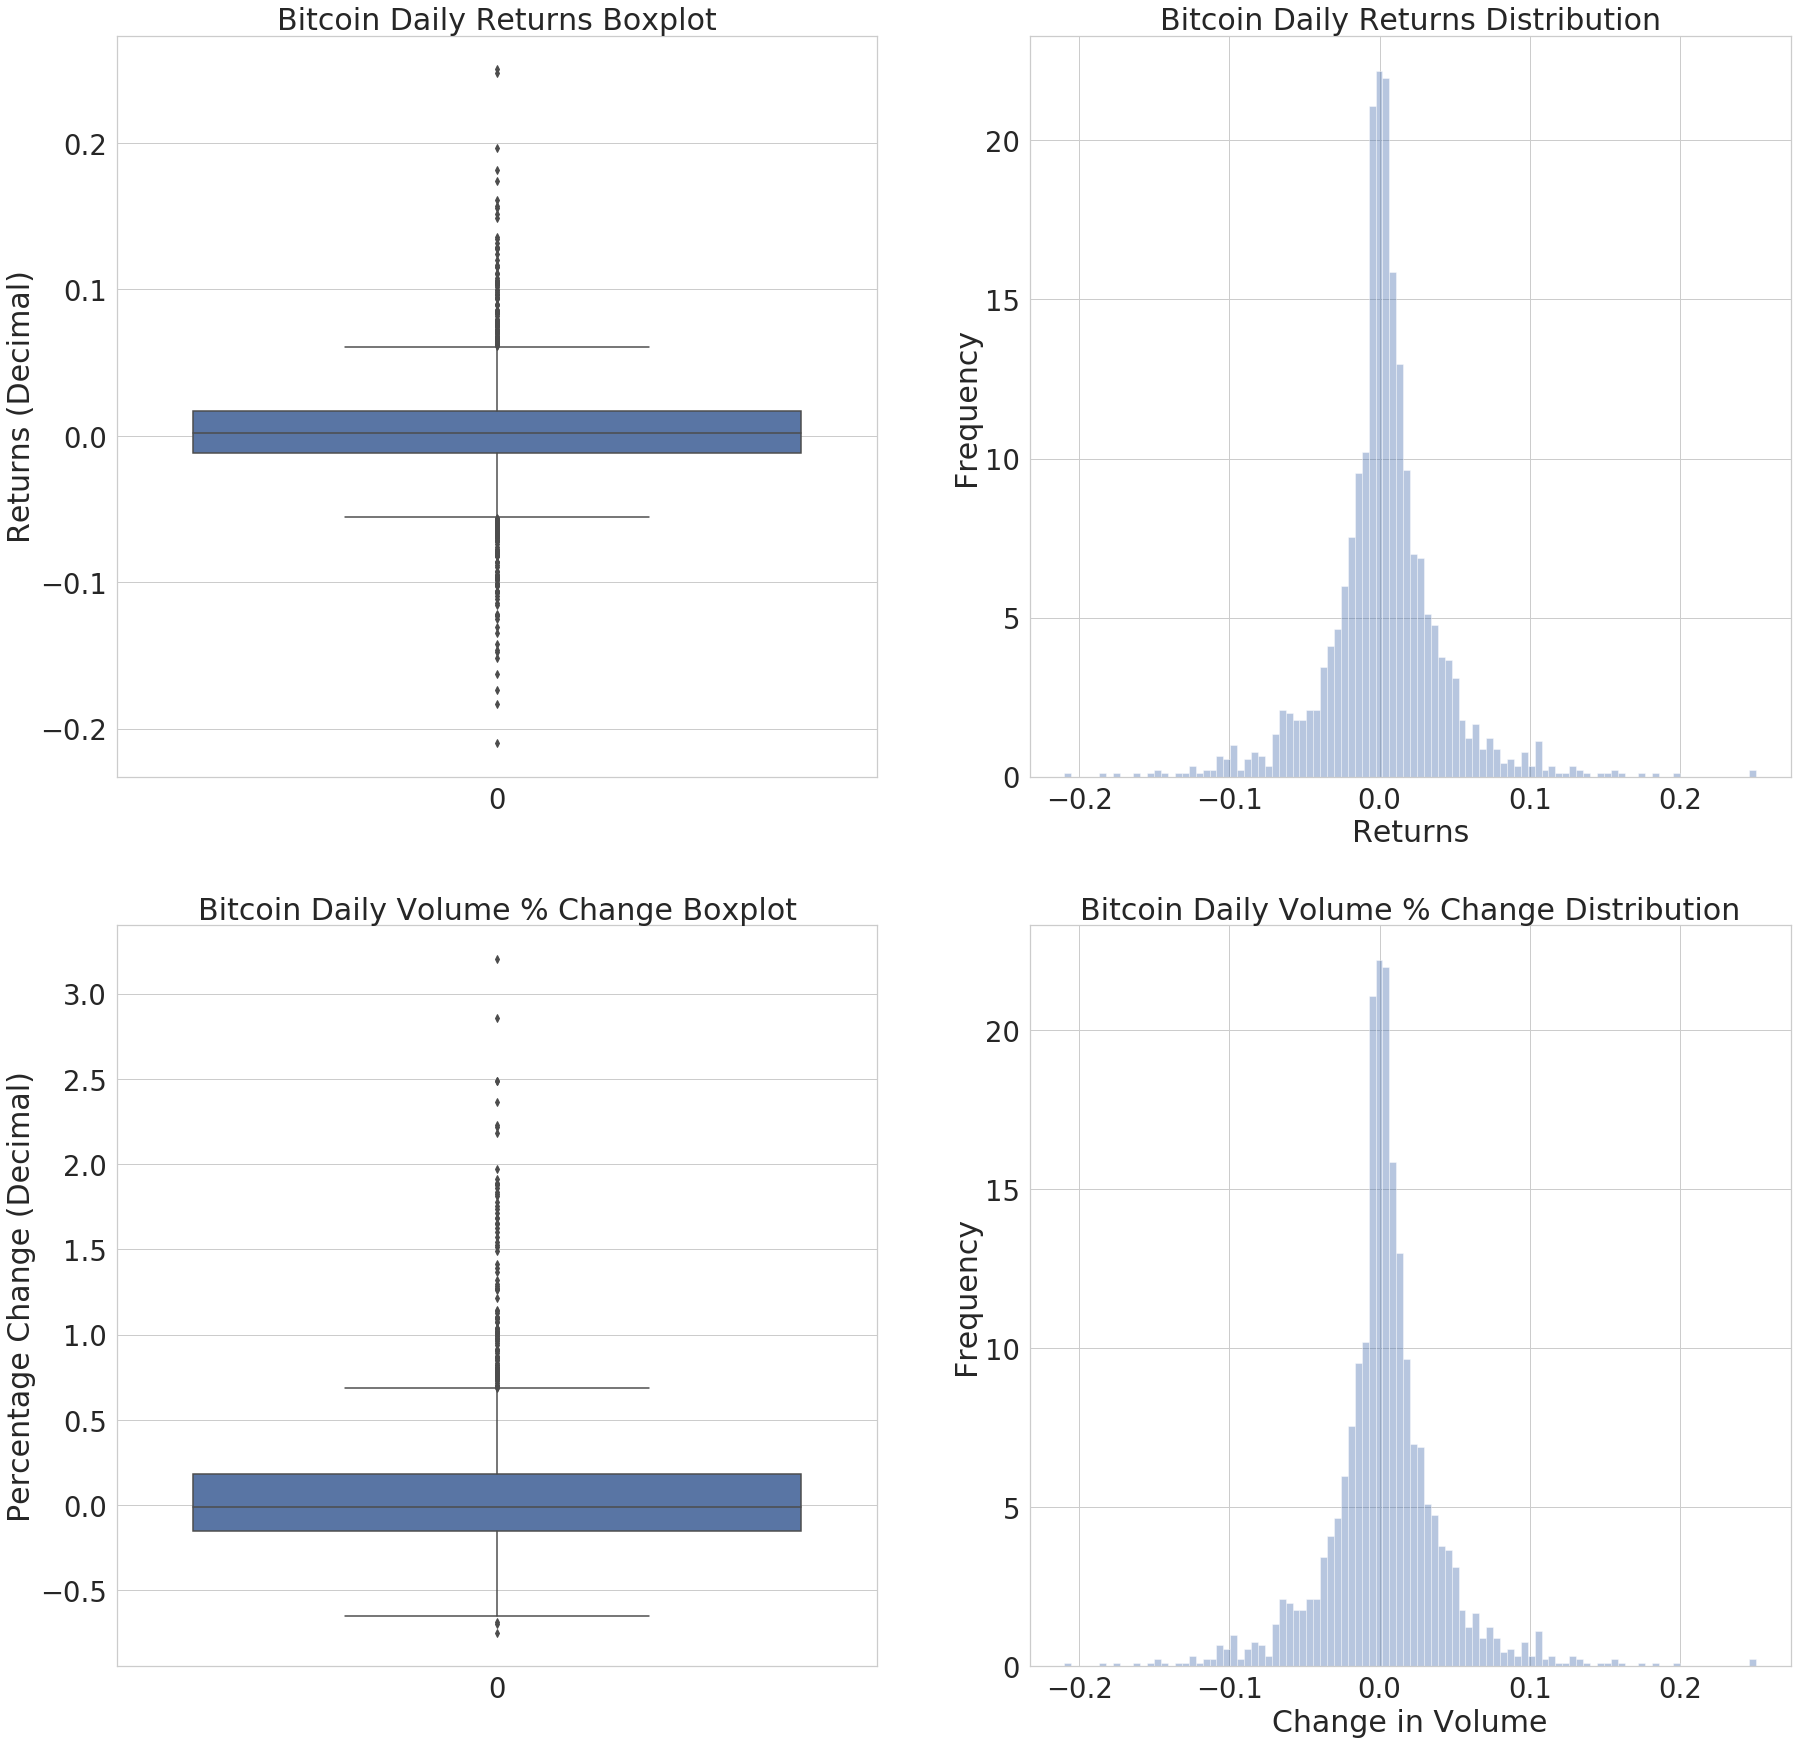

In [16]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(30,30))
sns.set(style="whitegrid", font_scale=2.5)

#first image
image1 = sns.boxplot(data=df['daily_pct_chg'], orient='v',ax=ax[0,0])
image1.set(ylabel='Returns (Decimal)', title='Bitcoin Daily Returns Boxplot')

#second image
image2 = sns.distplot(df['daily_pct_chg'],kde=False,norm_hist=True,bins=100,ax=ax[0,1])
image2.set(ylabel='Frequency', title='Bitcoin Daily Returns Distribution',xlabel='Returns')

#third image
image3 = sns.boxplot(data=df['daily_pct_chg_vol'], orient='v',ax=ax[1,0])
image3.set(ylabel='Percentage Change (Decimal)', title='Bitcoin Daily Volume % Change Boxplot')

#second image
image4 = sns.distplot(df['daily_pct_chg'],kde=False,norm_hist=True,bins=100,ax=ax[1,1])
image4.set(ylabel='Frequency', title='Bitcoin Daily Volume % Change Distribution',xlabel='Change in Volume')
plt.show()

As we can see from the above graphs, the daily returns and volume are centered around 0 which is what we would expect. From the first column of graphs, we also see that the volatility in volume is much greater than the volatility of returns by looking at the vertical spread of the box plot. The volatility in volume traded is part of the motivation to include it as an indicator in the timeseries momentum.

Lets also take a look to see how returns vary by days of the week.

Text(0, 0.5, 'Mean Returns (Decimal)')

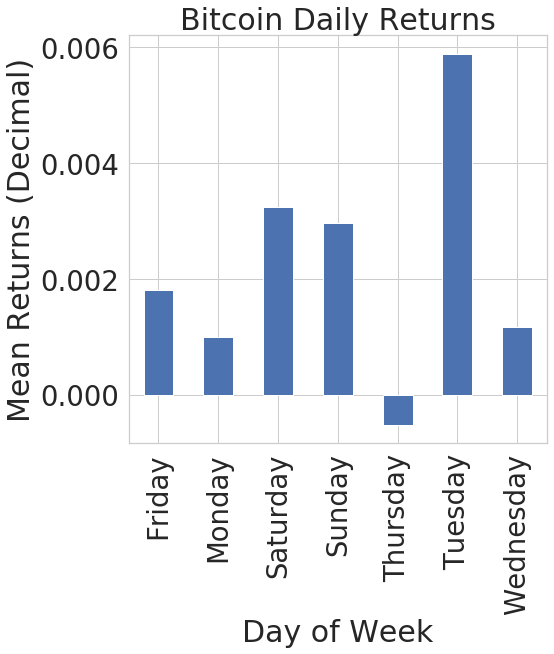

In [17]:
df['Day'] = df.index.day_name()
fig, ax = plt.subplots(figsize=(7.5,7.5))
df.groupby('Day')['daily_pct_chg'].mean().plot(kind='bar',ax=ax)
plt.title('Bitcoin Daily Returns')
plt.xlabel('Day of Week')
plt.ylabel('Mean Returns (Decimal)')

From the plot above, we can see that there is quite a bit of variability in the mean returns by day. I will therefore add dummy variables indicating the day of the week to try extract more information from the dataset for the models.

In [18]:
#creating 6 dummies instead of 7 by specifying drop_first=True to avoid the dummy variable trap
df = pd.concat([df,pd.get_dummies(df['Day'],drop_first=True)],axis=1)
df.head()

,Open,Volume,daily_pct_chg,daily_pct_chg_vol,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,
2014-09-18,456.859985,34483200,-0.019328,0.637628,Thursday,0,0,0,1,0,0
2014-09-19,424.102997,37919700,-0.071700,0.099657,Friday,0,0,0,0,0,0
2014-09-20,394.673004,36863600,-0.069394,-0.027851,Saturday,0,1,0,0,0,0
2014-09-21,408.084991,26580100,0.033983,-0.278961,Sunday,0,0,1,0,0,0
2014-09-22,399.100006,24127600,-0.022017,-0.092268,Monday,1,0,0,0,0,0


Now create lagged values for daily returns

In [19]:
for i in range(1,5):
    column_name = 'lag_return_' + str(i)
    df[column_name] = df['daily_pct_chg'].shift(i)
del i
print(df.head(5))

                  Open    Volume  daily_pct_chg  daily_pct_chg_vol       Day  \
Date                                                                           
2014-09-18  456.859985  34483200      -0.019328           0.637628  Thursday   
2014-09-19  424.102997  37919700      -0.071700           0.099657    Friday   
2014-09-20  394.673004  36863600      -0.069394          -0.027851  Saturday   
2014-09-21  408.084991  26580100       0.033983          -0.278961    Sunday   
2014-09-22  399.100006  24127600      -0.022017          -0.092268    Monday   

            Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
Date                                                                 
2014-09-18       0         0       0         1        0          0   
2014-09-19       0         0       0         0        0          0   
2014-09-20       0         1       0         0        0          0   
2014-09-21       0         0       1         0        0          0   
2014-09-22       1 

Repeat for the lagged volume indicators

In [20]:
for i in range(1,5):
    column_name = 'lag_return_vol_' + str(i)
    df[column_name] = df['daily_pct_chg_vol'].shift(i)
df.dropna(inplace=True)
print(df.head(5))

                  Open    Volume  daily_pct_chg  daily_pct_chg_vol        Day  \
Date                                                                            
2014-09-22  399.100006  24127600      -0.022017          -0.092268     Monday   
2014-09-23  402.092010  45099500       0.007497           0.869208    Tuesday   
2014-09-24  435.751007  30627700       0.083710          -0.320886  Wednesday   
2014-09-25  423.156006  26814400      -0.028904          -0.124505   Thursday   
2014-09-26  411.428986  21460800      -0.027713          -0.199654     Friday   

            Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
Date                                                                 
2014-09-22       1         0       0         0        0          0   
2014-09-23       0         0       0         0        1          0   
2014-09-24       0         0       0         0        0          1   
2014-09-25       0         0       0         1        0          0   
2014-09-26  

# Predictions

The next part of this project will investigate the predictive accuracy of several models including logstic and neural networks. To make it easier to compare between models, I've decided to frame the problem as a classification problem where I will be predicting whether the daily returns move up or down, a binary outcome, instead of how large the returns are. I've printed out a few error scores for the models below after each cell, but I also compare them in a graph later on.

In [21]:
#create a binary column for daily returns where 0 represents the negative returns and 1 is the positive returns
def fn_binary(value):
    if value < 0:
        return 0 
    else:
        return 1
df['target'] = df['daily_pct_chg'].apply(fn_binary)
print(df.columns)

Index(['Open', 'Volume', 'daily_pct_chg', 'daily_pct_chg_vol', 'Day', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'lag_return_1', 'lag_return_2', 'lag_return_3', 'lag_return_4',
       'lag_return_vol_1', 'lag_return_vol_2', 'lag_return_vol_3',
       'lag_return_vol_4', 'target'],
      dtype='object')


## Training and test data
First we'll make the training and test data for our models. We'll use a random 90% of the data for training and the remaining 10% of the data to see how our models generalize to data they haven't seen before.

In [22]:
#Split and sort into train, test 
dftrain, dftest = train_test_split(df, test_size=0.1, random_state=101)

#training data, drop the columns we don't need
trainy = pd.to_numeric(dftrain['target'])
trainx = (dftrain.drop(['Open','Volume','daily_pct_chg','Day','target'], axis=1))
#Test data
testy = pd.to_numeric(dftest['target'])
testx = dftest.drop(['Open','Volume','daily_pct_chg','Day', 'target'], axis=1)

print(trainx.shape)
print(testx.shape)


(1758, 15)
(196, 15)


Let's first train a logistic regression and analyze the results.

In [23]:
model_logistic = LogisticRegression()
model_logistic.fit(trainx, trainy)

logistic_train_accuracy = model_logistic.score(trainx,trainy)
logistic_test_accuracy = model_logistic.score(testx,testy)
print(f'Logistic Train Accuracy is: {logistic_train_accuracy}')
print(f'Logistic Test Accuracy is: {logistic_test_accuracy}')

log_loss_logistic_train = sk.metrics.log_loss(trainy, model_logistic.predict(trainx))
log_loss_logistic_test = sk.metrics.log_loss(testy, model_logistic.predict(testx))
print(f'Logistic LogLoss Train is: {log_loss_logistic_train}')
print(f'Logistic LogLoss Test is: {log_loss_logistic_test}')

Logistic Train Accuracy is: 0.5523321956769056
Logistic Test Accuracy is: 0.5255102040816326
Logistic LogLoss Train is: 15.462214756886304
Logistic LogLoss Test is: 16.388668204555312


Let's try a neural network classifier. We should scale the data to make it easier for the model to train.

In [24]:
scaler = StandardScaler()
#fit and transform on the input training data
trainx = scaler.fit_transform(trainx)
#use the same scaler to transform the input test data
testx = scaler.transform(testx)

#early stopping to try and avoid overfitting on the training data
#this should lead to better generalization to test data
model_nn = MLPClassifier(early_stopping=True, hidden_layer_sizes=(20,20,20))
model_nn.fit(trainx, trainy)

nn_train_accuracy = model_nn.score(trainx,trainy)
nn_test_accuracy = model_nn.score(testx,testy)
print(f'Neural Network Train Accuracy is: {nn_train_accuracy}')
print(f'Neural Network Test Accuracy is: {nn_test_accuracy}')

log_loss_nn_train = sk.metrics.log_loss(trainy, model_nn.predict(trainx))
log_loss_nn_test = sk.metrics.log_loss(testy, model_nn.predict(testx))
print(f'Neural Network LogLoss Train is: {log_loss_nn_train}')
print(f'Neural Network LogLoss Test is: {log_loss_nn_test}')

Neural Network Train Accuracy is: 0.5443686006825939
Neural Network Test Accuracy is: 0.47959183673469385
Neural Network LogLoss Train is: 15.737233471176113
Neural Network LogLoss Test is: 17.974575312668442


Now I'll try a Gradient Boosting Classifier, with an implementation of a grid search cross validation to try and tune some of the parameters of the model. When trying to use this model to make predictions for trading with real money, often the uncertainity around the prediction influences how much money is invested, therefore I've also implemented a log loss error for the GridSearchCV. The logloss penalizes the model when it predicts a high probability and is wrong and therefore emphasizes accountability.

In [25]:
opt_max_depth=2
opt_n_estimators=500
opt_learning_rate=0.1

#Optimize some parameters
param_test1 = {'n_estimators':[100,200,600],'learning_rate':[0.001,0.01,0.1],'max_depth':[1,3,4]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(),
                                                              param_grid = param_test1,scoring='accuracy',
                                                              cv=5, verbose=0)
gsearch1.fit(trainx, trainy)
opt_n_estimators=gsearch1.best_params_['n_estimators']
opt_learning_rate=gsearch1.best_params_['learning_rate']
opt_max_depth=gsearch1.best_params_['max_depth']

model_tree = GradientBoostingClassifier(n_estimators=opt_n_estimators,
                                max_depth=opt_max_depth,learning_rate=opt_learning_rate)
model_tree.fit(trainx,trainy
              )
tree_train_accuracy = model_nn.score(trainx,trainy)
tree_test_accuracy = model_nn.score(testx,testy)
print(f'Tree Train Accuracy is: {tree_train_accuracy}')
print(f'Tree Test Accuracy is: {tree_test_accuracy}')

log_loss_tree_train = sk.metrics.log_loss(trainy, model_tree.predict(trainx))
log_loss_tree_test = sk.metrics.log_loss(testy, model_tree.predict(testx))
print(f'Tree LogLoss Train is: {log_loss_tree_train}')
print(f'Tree LogLoss Test is: {log_loss_tree_test}')

Tree Train Accuracy is: 0.5443686006825939
Tree Test Accuracy is: 0.47959183673469385
Tree LogLoss Train is: 12.063293102727505
Tree LogLoss Test is: 16.036207233257343


## Classification Model Comparisons
Now we'll compare the error scores for the three models 

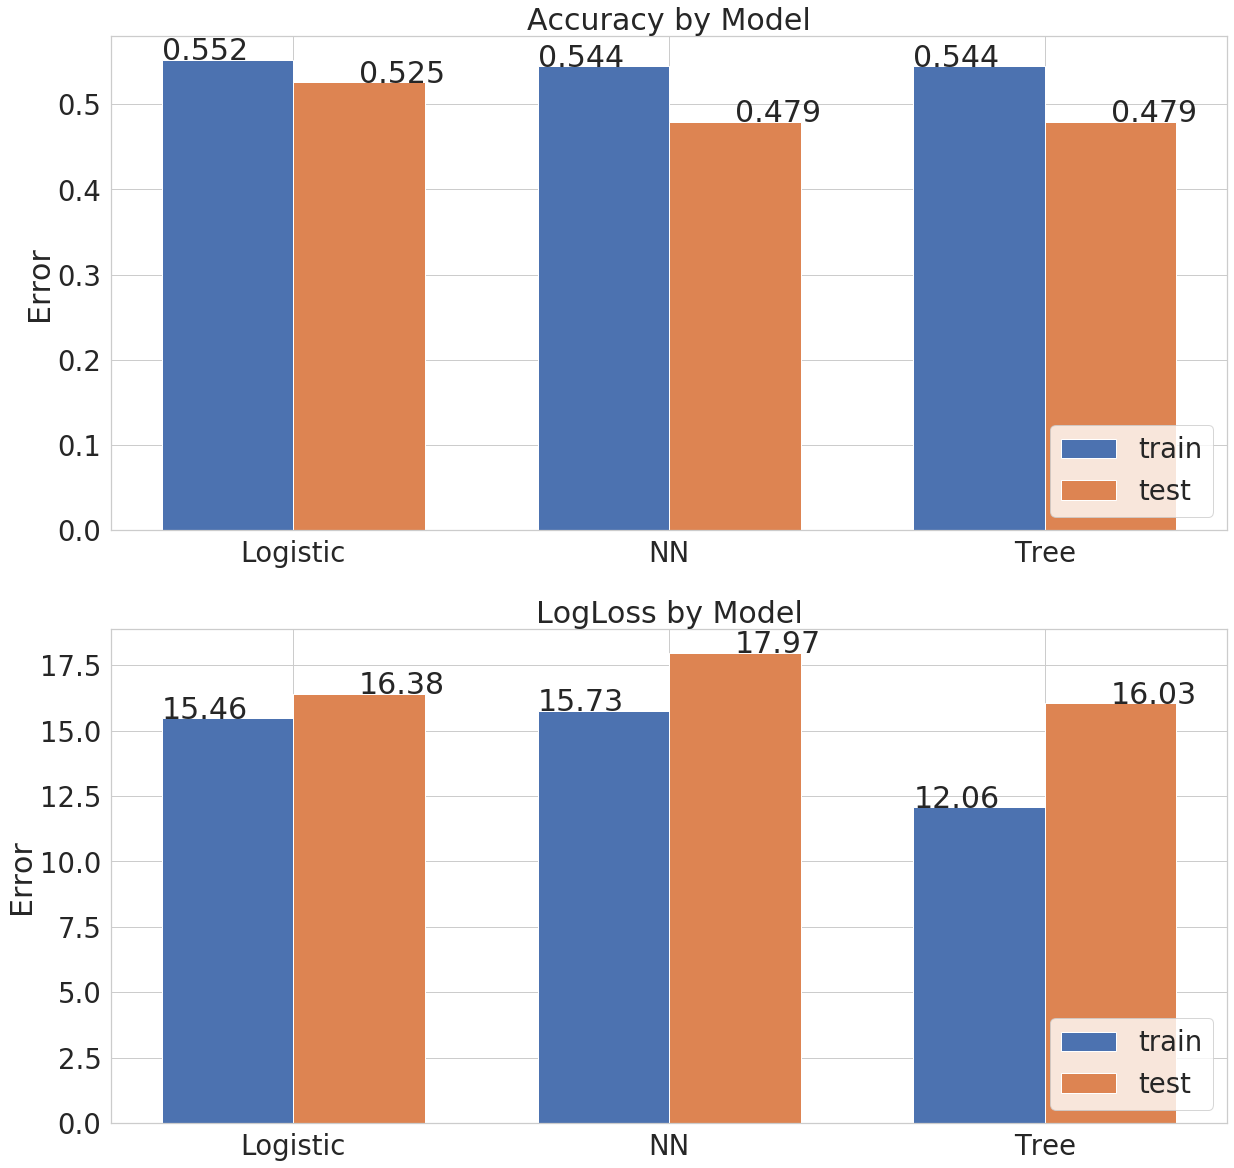

In [26]:
train_accuracy = (logistic_train_accuracy, nn_train_accuracy, tree_train_accuracy)
test_accuracy = (logistic_test_accuracy, nn_test_accuracy, tree_test_accuracy)
train_logloss = (log_loss_logistic_train, log_loss_nn_train, log_loss_tree_train)
test_logloss = (log_loss_logistic_test, log_loss_nn_test, log_loss_tree_test)

ind = np.arange(len(train_accuracy))  # the x locations for the groups
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(20,20),nrows=2)
rects1 = ax[0].bar(ind - width/2, train_accuracy, width,
                label='train')
rects2 = ax[0].bar(ind + width/2, test_accuracy, width,
                label='test')
rects3 = ax[1].bar(ind - width/2, train_logloss, width,
                label='train')
rects4 = ax[1].bar(ind + width/2, test_logloss, width,
                label='test')


        
# Add some text for labels, title and custom x-axis tick labels, etc.

ax[0].set_ylabel('Error')
ax[0].set_title('Accuracy by Model')
ax[0].set_xticks(ind)
ax[0].set_xticklabels(('Logistic', 'NN', 'Tree'))
ax[0].legend(loc='lower right')

ax[1].set_ylabel('Error')
ax[1].set_title('LogLoss by Model')
ax[1].set_xticks(ind)
ax[1].set_xticklabels(('Logistic', 'NN', 'Tree'))
ax[1].legend(loc='lower right')

x=0
for i in train_accuracy:
    #ax[0].text(ind[0]-(width/2),logistic_train_accuracy,str(logistic_train_accuracy)[0:4])
    ax[0].text(ind[x]-(width),i,str(i)[0:5])
    x = x + 1

x=0
for i in test_accuracy:
    ax[0].text(ind[x]+(width/2),i,str(i)[0:5])
    x = x + 1
    
x=0
for i in train_logloss:
    ax[1].text(ind[x]-(width),i,str(i)[0:5])
    x = x + 1

x=0
for i in test_logloss:
    ax[1].text(ind[x]+(width/2),i,str(i)[0:5])
    x = x + 1





## Accuracy Results
From the above graphs, we see that the logistic regression performs better in terms of accuracy on both the train and test sets. As it is a classification problem, the accuracy is just the amount of predictions that it get's correct. Therefore the accuracy value of 52.5 on the test set means that it correctly predicts 52.5% of the time. Although this may not seem like a good score, predicting a financial market is difficult and predicting over 50% accuracy could lead to a profitable trading strategy, however, that is beyond the scope of this project.

## Log Loss Results
In terms of log loss, which may be a more appropriate measure to use as a trading strategy, the Gradient Boosting Classifier (Tree model) performed the best on the test set with a log loss error score of 16.03. It should be noted that a Grid Search was only implemented for the Gradient Boosting Classifier and not for the Neural Network due to computation power of the Jupyter notebook and scikitlearn packages.

# Next Step - Predicting the magnitude of the change
Now I will change from a classification problem back to a regression problem that will allow me predict the magnitude of the future daily return. I will compare the results between a linear regression model and a neural network.

In [27]:
#Split and sort into train, test 
dftrain, dftest = train_test_split(df, test_size=0.1, random_state=101)

#training data, drop the columns we don't need
trainy = pd.to_numeric(dftrain['daily_pct_chg'])
trainx = (dftrain.drop(['Open','Volume','target','Day','target','daily_pct_chg'], axis=1))
#Test data
testy = pd.to_numeric(dftest['daily_pct_chg'])
testx = dftest.drop(['Open','Volume','target','Day', 'target', 'daily_pct_chg'], axis=1)

linear_model= LinearRegression()
linear_model.fit(trainx, trainy)

mse_linear_train = sk.metrics.mean_squared_error(trainy, linear_model.predict(trainx))
mse_linear_test = sk.metrics.mean_squared_error(testy, linear_model.predict(testx))
print(f'Linear MSE Train is: {mse_linear_train*1000}')
print(f'Linear MSE Test is: {mse_linear_test*1000}')


nn_model= MLPRegressor(hidden_layer_sizes=(20,20,20))
nn_model.fit(trainx, trainy)

mse_nn_train = sk.metrics.mean_squared_error(trainy, nn_model.predict(trainx))
mse_nn_test = sk.metrics.mean_squared_error(testy, nn_model.predict(testx))
print(f'Neural Network MSE Train is: {mse_nn_train*1000}')
print(f'Neural Network MSE Test is: {mse_nn_test*1000}')


Linear MSE Train is: 1.437706353931729
Linear MSE Test is: 1.502959519956661
Neural Network MSE Train is: 1.708511977501341
Neural Network MSE Test is: 1.704793189477996


The Linear model performs better in terms of mean squared error on both the training and test set.
Let's now try to visualize how the models compare in their predictions with the real values of the returns.

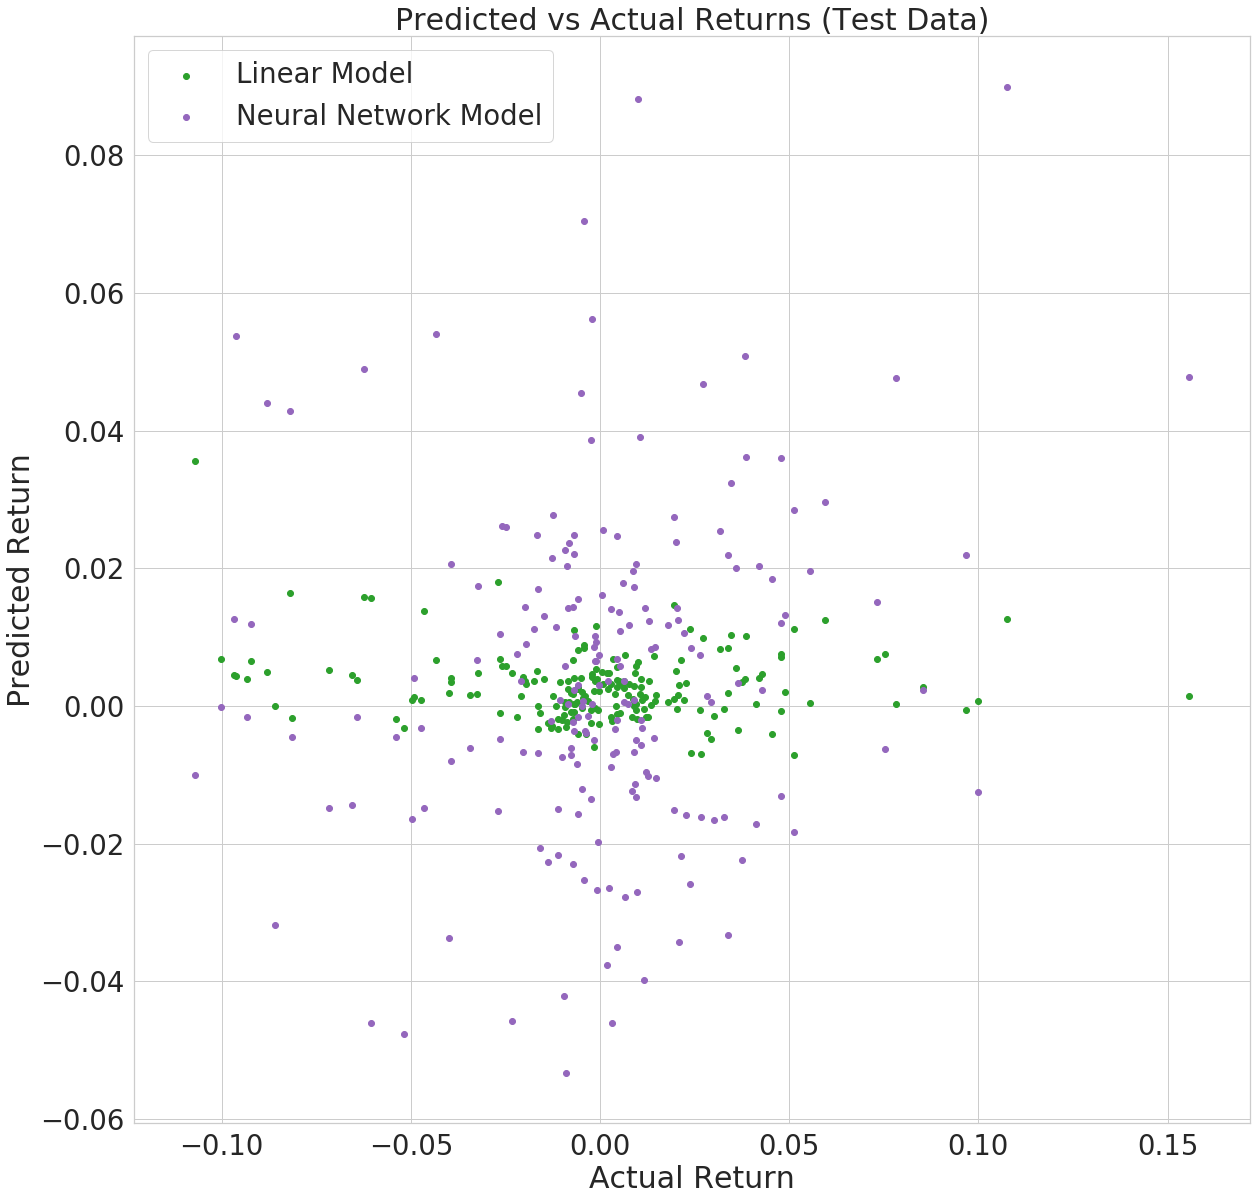

In [28]:
df_results = pd.DataFrame(data={'Linear':linear_model.predict(testx),
                          'Neural Network':nn_model.predict(testx),
                               'Actual':testy})

f, ax = plt.subplots(figsize=(20,20))
ax.scatter(testy, linear_model.predict(testx),color='#2ca02c', label='Linear Model')#green
ax.scatter(testy, nn_model.predict(testx),  color='#9467bd', label='Neural Network Model')#purple
ax.legend()
ax.set_ylabel('Predicted Return')
ax.set_title('Predicted vs Actual Returns (Test Data)')

ax.set_xlabel('Actual Return')
plt.show()

From the above graph we see that the linear model(green) predicts values much closer to 0 while the Neural Network model has a much wider range to it's predictions. Although the linear model does have lower error scores, it's unclear whether either of the models would be sufficiently accurate to implement in a trading system.

Therefore to conclude, this project was mostly just to gain experience working with a dataset and using some of Python's prediction tools as an extension to my thesis. It's clear that a simple logistic model performs well in a classification problem and a linear regression performs well on non-binary data, however, it is important to note that the hyperparameter tuning of the Neural Network and Gradient Boosting models is an art of it's own and therefore we cannot conclude which model is definitively the best.